In [3]:
# make sure the PWD is set to the main `toto` directory
%cd ..

import os

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch

from data.util.dataset import MaskedTimeseries
from inference.forecaster import TotoForecaster
from model.toto import Toto

# These lines make gpu execution in CUDA deterministic
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.use_deterministic_algorithms(True)

/home/walter_littor_al/toto/toto


/opt/conda/envs/toto/lib/python3.13/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


# Time series forecasting with Toto

In this notebook, you'll learn how to perform inference with Toto for multivariate time series forecasting on the classic ETT dataset. Toto is a foundation model used for *zero-shot* forecasting,
meaning no training is required. We simply provide the historical context of a time series to Toto as input, and Toto produces forecasts of the desired length.

## Prerequisites

You'll need to run this with a CUDA-capable device. In order to get the fastest inference performance, please use an Ampere or newer architecture, as these support the xFormers fused kernel implementations for SwiGLU and Memory-Efficient Attention.

Make sure you've cloned the repo and installed dependencies with `pip install -r requirements.txt`. When running this notebook, make sure the working directory is set to `<repository_root>/toto`.

This notebook also assumes that you've downloaded the `ETT-small` dataset locally. It can be obtained from the [official repo](https://github.com/zhouhaoyi/ETDataset).


## Load data
As an example, we'll look at the ETTm1 sub-dataset:

In [4]:
ETT_LOCAL_PATH = "/home/walter_littor_al/ETDataset/ETT-small"  # UPDATE WITH YOUR LOCAL PATH

df = (
    pd.read_csv(f"{ETT_LOCAL_PATH}/ETTm1.csv")
    .assign(date=lambda df: pd.to_datetime(df["date"]))
    .assign(timestamp_seconds=lambda df: (df.date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))
)

df

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,timestamp_seconds
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,1467331200
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999,1467332100
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000,1467333000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000,1467333900
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,1467334800
...,...,...,...,...,...,...,...,...,...
69675,2018-06-26 18:45:00,9.310,3.550,5.437,1.670,3.868,1.462,9.567000,1530038700
69676,2018-06-26 19:00:00,10.114,3.550,6.183,1.564,3.716,1.462,9.567000,1530039600
69677,2018-06-26 19:15:00,10.784,3.349,7.000,1.635,3.746,1.432,9.426000,1530040500
69678,2018-06-26 19:30:00,11.655,3.617,7.533,1.706,4.173,1.523,9.426000,1530041400


## Preprocess data

In the following section, we prepare the data in the expected input format of Toto.

Toto expects inputs to be multivariate time series data in the shape

$\text{Variate} \times \text{Time Steps}$

or, with optional batch dimension:

$\text{Batch} \times \text{Variate} \times \text{Time Steps}$

For illustration, we'll try to predict the last 96 steps of the ETTm1 time series across its 7 covariates. We'll do this using the preceding 1024 steps as context. 2048 gives a good balance of speed vs. performance; you may want to experiment with different context lengths depending on your dataset. Toto was trained with a max context length of 4096, but can extrapolate to even longer contexts. 


In [6]:
context_length = 4096
prediction_length = 336

Slice the ETTm1 data accordingly

In [15]:
feature_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
n_variates = len(feature_columns)
interval = 60 * 15  # 15-min intervals
input_df = df.iloc[-(context_length+prediction_length):-prediction_length]
target_df = df.iloc[-prediction_length:]


DEVICE = "cuda"
input_series = torch.from_numpy(input_df[feature_columns].values.T).to(torch.float).to(DEVICE)
input_series.shape

torch.Size([7, 4096])

Add timestamp features to the data. Note: the current version of Toto does not use these features; it handles series of different time resolutions implicitly. However, future versions may take this into account, so the API expects timestamps to be passed in.

In [18]:
timestamp_seconds = torch.from_numpy(input_df.timestamp_seconds.values.T).expand((n_variates, context_length)).to(input_series.device)
time_interval_seconds=torch.full((n_variates,), interval).to(input_series.device)
start_timestamp_seconds = timestamp_seconds[:, 0]

Toto expects its inputs in the form of a `MaskedTimeseries` dataclass.

In [19]:
inputs = MaskedTimeseries(
    series=input_series,
    # The padding mask should be the same shape as the input series.
    # It should be 0 to indicate padding and 1 to indicate valid values.
    padding_mask=torch.full_like(input_series, True, dtype=torch.bool),
    # The ID mask is used for packing unrelated time series along the Variate dimension.
    # This is used in training, and can also be useful for large-scale batch inference in order to
    # process time series of different numbers of variates using batches of a fixed shape.
    # The ID mask controls the channel-wise attention; variates with different IDs cannot attend to each other.
    # If you're not using packing, just set this to zeros.
    id_mask=torch.zeros_like(input_series),
    # As mentioned above, these timestamp features are not currently used by the model;
    # however, they are reserved for future releases.
    timestamp_seconds=timestamp_seconds,
    time_interval_seconds=time_interval_seconds,
)

Now our data is ready!

## Load Toto checkpoint

Download a Toto checkpoint from Hugging Face (TBD) to a local directory

In [ ]:
# # code to load weights from a local checkpoint -- could be mounted from bucket.  
# toto = Toto.load_from_checkpoint("path to checkpoint", map_location=DEVICE)
# toto = toto.to(DEVICE)

In [20]:
toto = Toto.from_pretrained('Datadog/Toto-Open-Base-1.0')
toto.to(DEVICE)

# Optionally enable Torch's JIT compilation to speed up inference. This is mainly
# helpful if you want to perform repeated inference, as the JIT compilation can
# take time to wrm up.
toto.compile()

We generate multistep, autoregressive forecasts using the `TotoForecaster` class. 

In [21]:
forecaster = TotoForecaster(toto.model)
forecast = forecaster.forecast(
    inputs,
    # We can set any number of timesteps into the future that we'd like to forecast. Because Toto is an autoregressive model,
    # the inference time will be longer for longer forecasts. 
    prediction_length=prediction_length,
    # TOTOForecaster draws samples from a predicted parametric distribution. The more samples, the more stable and accurate the prediction.
    # This is especially important if you care about accurate prediction intervals in the tails.
    # Toto's evaluations were performed using 256 samples. Set this according to your compute budget.
    num_samples=256,
    # TOTOForecaster also handles batching the samples in order to control memory usage.
    # Set samples_per_batch as high as you can without getting OOMs for maximum performance.
    # If you're doing batch inference, the effective batch size sent to the model is (batch_size x samples_per_batch).
    # In this notebook, we're doing unbatched inference, so the effective batch size is samples_per_batch.
    samples_per_batch=256,
    # KV cache should significantly speed up inference, and in most cases should reduce memory usage too.
    use_kv_cache=True,
)

## Visualize the forecasts

We can plot our forecasts and confidence intervals against the ground truth:

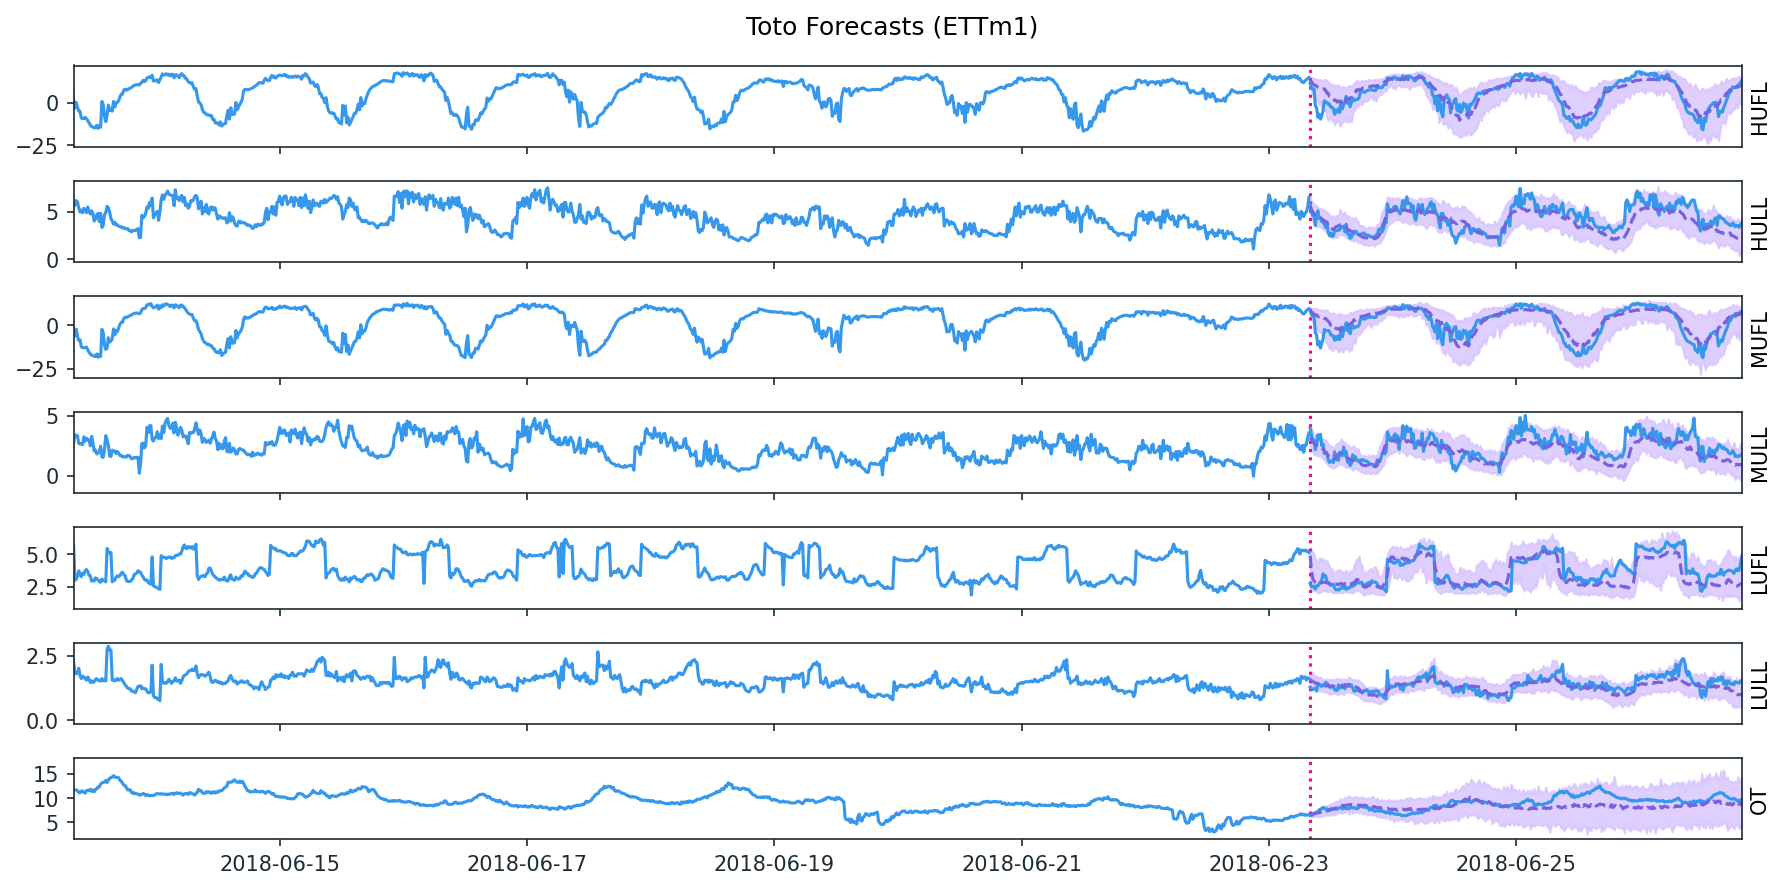

In [22]:
DARK_GREY = "#1c2b34"
BLUE = "#3598ec"
PURPLE = "#7463e1"
LIGHT_PURPLE = "#d7c3ff"
PINK = "#ff0099"

matplotlib.rc("axes", edgecolor=DARK_GREY)
fig = plt.figure(figsize=(12, 6), layout="tight", dpi=150)
plt.suptitle("Toto Forecasts (ETTm1)")

for i, feature in enumerate(feature_columns):
    # Configure axes
    plt.subplot(n_variates, 1, i + 1)
    if i != 6:
        # only show x tick labels on the bottom subplot
        fig.gca().set_xticklabels([])
    fig.gca().tick_params(axis="x", color=DARK_GREY, labelcolor=DARK_GREY)
    fig.gca().tick_params(axis="y", color=DARK_GREY, labelcolor=DARK_GREY)
    fig.gca().yaxis.set_label_position("right")
    plt.ylabel(feature)
    plt.xlim(input_df.date.iloc[-960], target_df.date.iloc[-1])
    plt.axvline(target_df.date.iloc[0], color=PINK, linestyle=":")

    # Plot ground truth
    plt.plot(input_df["date"], input_df[feature], color=BLUE)
    plt.plot(target_df["date"], target_df[feature], color=BLUE)

    # Plot point forecasts
    plt.plot(
        target_df["date"],
        np.median(forecast.samples.squeeze()[i].cpu(), axis=-1),
        color=PURPLE,
        linestyle="--",
    )

    # Plot quantiles
    alpha = 0.05
    qs = forecast.samples.quantile(q=torch.tensor([alpha, 1 - alpha], device=forecast.samples.device), dim=-1)
    plt.fill_between(
        target_df["date"],
        qs[0].squeeze()[i].cpu(),
        qs[1].squeeze()[i].cpu(),
        color=LIGHT_PURPLE,
        alpha=0.8,
    )